## Tech tutorial: clean data munging in python (or, "R-envy for pythonistas")

Since this is a technical talk, we decided to try out three libraries we hadn't used much:
 - [pandas-ply](http://pythonhosted.org/pandas-ply/), a lightweight library from coursera
   that adds some methods to pandas datafrmes
 - [dplython](https://github.com/dodger487/dplython), a port of the most-often-used
   parts of the popular `dplyr` R library to python
 - [rpy2](http://rpy.sourceforge.net/rpy2/doc-dev/html/introduction.html), a library
   allowing python code to use R that has
   [strong pandas support](http://pandas.pydata.org/pandas-docs/stable/r_interface.html)

Why not just use `R`? A few reasons:
  - because Sara and I use python on a day-to-day basis, it's faster for
    us to get started in python
      - This counts for a lot on pro-bono projects where time is limited
  - with mid-size datasets this is even more true, because R's semantics aren't
    obvious to novices, and it's easy to unwittingly write expensive code
  - at the outset of a data science project it's not always clear whether the whole
    analysis will wind up being dataframe-oriented. If we wind up wanting lists, sets, or
    dictionaries, these are much easier for us to use from python than from `R`
  
But R has a lot of great tools for statistical data, so it's great to get the best
of both worlds by using `R`-inspired data manipulation libraries, and using `R` itself
whenever the python libraries just aren't as good.

In [1]:
from __future__ import print_function

# scipy and numpy seem to be out of sync which produces a bunch of warnings we want to hide
import warnings
warnings.filterwarnings('ignore')

%pylab inline
import numpy as np
import pandas as pd
import tdx


Populating the interactive namespace from numpy and matplotlib


## A toy dataset and data munging problem

Here's a simple pandas DataFrame. Let's imagine that we want to:
  - ignore rows where a column `y` is bigger than 10
  - double all the values of `x`
  - sum up the results for each group in `label`

In [2]:
dat = pd.DataFrame({
    'label': ['a', 'b', 'a', 'a', 'b', 'b'],
    'x':  [1, 2, 3, 4, 8, 9],
    'y':  [10, 2, 30, 4, 8, 90],
})

dat

,label,x,y
0,a,1,10
1,b,2,2
2,a,3,30
3,a,4,4
4,b,8,8
5,b,9,90


### a solution in vanilla pandas code

What don't I like about this?
  - you can't do everything in a single method chain, it's a mix of indexing operations and methods
  - the code doesn't read like sql, you have to parse each line carefully
  - to make a new column we have to mutate the dataframe in-place, which means we either destroy the
    original data or have to make a copy (here we use `dat_` as our copy)

In [3]:
dat_ = dat[['label', 'x', 'y']]   # make a copy so that defining 'z' won't modify `dat`
dat_ = dat_[dat['y'] < 10]        # use slice operator for dropping rows
dat_['z'] = 2 * dat['x']          # assign to the dataframe to get a computed column
(dat_[['label', 'z']]             # mix indexing with method chaining = code is harder to skim
 .groupby('label')
 .sum()
 )

,z
label,
a,8
b,20


### what does this example look like with `pandas-ply`?

The `pandas_ply` library introduces just two new methods, 
  - `ply_select`: lets you pick out columns and make new ones, like SQL `SELECT`
  - `ply_where`: lets you drop rows, like SQL `WHERE`
  
Just these two methods greatly increase how much we can do with clean, functional method chaining.

In [4]:
import pandas_ply
from pandas_ply import X as pX
pandas_ply.methods.install_ply(pd)

(dat
 .ply_where(pX['y'] < 10)
 .ply_select(label=pX['label'],
             z=2*pX['x'])
 .groupby('label')
 .sum())

,z
label,
a,8
b,20


### what does this example look like with `dplython`?

The `dplython` package is a clone of a lot of the most popular parts of the `dplyr` library.

It overloads the bitshift operator to simulate R's `%>%`.

In [5]:
import dplython as dp
from dplython import X as dX

(dp.DplyFrame(dat) >>
 dp.sift(dX['y'] < 10) >>              # `sift` because `filter` is a keyword in python
 dp.transmute(label=dX['label'],
              z=2*dX['x']) >>
 dp.group_by(dX['label']) >>
 dp.summarize(z=dX['z'].sum())
)
# note that dplython isn't converting `label` to an index

,label,z
0,a,8
1,b,20


### Where does `pandas-ply` really shine?

Here's a more complex example, that shows how method chaining in `pandas_ply` leads to much more declarative code, almost like SQL:

In [6]:
df_a = pd.DataFrame({'x': ['a', 'b', 'c'], 'y': [1, 2, 3], 'z': [3.4, 3.5, 3.6]})
df_a


,x,y,z
0,a,1,3.4
1,b,2,3.5
2,c,3,3.6


In [7]:
df_b = pd.DataFrame({'x': ['a', 'b', 'c', 'c'], 'w': [True, True, False, True], 'v': [1.1, 1.2, 1.3, 1.4]})
df_b

,v,w,x
0,1.1,True,a
1,1.2,True,b
2,1.3,False,c
3,1.4,True,c


In [8]:
(
    df_a
    .ply_select(
        x=pX['x'],
        y_doubled=2*pX['y']
     )
    .set_index('x')
    .join(
        df_b
        .ply_where(pX['w'])
        .ply_select(x=pX['x'],
                    v=pX['v'])
     .groupby('x')
        .max()
     )
    .ply_select(
        y_doubled=pX['y_doubled'],
        v_max=pX['v']
    )
    .reset_index()
)

,x,v_max,y_doubled
0,a,1.1,2
1,b,1.2,4
2,c,1.4,6


### Where does `dplython` really shine?

If you're already a `dplyr` expert, and you use python but can't get used to the pandas
api, you might find `dplython` more productive in general.

Personally I prefer `pandas_ply` most of the time, but there's one operation that I
have struggled repeatedly to do in `pandas`: group a dataframe, and then reate a new column
which is a function of the one-group dataframes.

The docs suggest that `groupby` with `transform` or `apply` should do the
trick, but I never seem to make it work. And I know from talking with colleagues that I'm not
the only one.

On the other hand `dplyr`, and hence `dplython`, have exactly the functionality I'm looking for:
`group_by` combined with `mutate`.

Here's an example: we want to group by `label` and double only the *last* `x` value for each
group. Note that because the `dX` context manager,
not an actual dataframe but rather a kind of "future" on one, we use `pipe` to send the
`x` column to
our function rather than passing it directly

In [9]:
dplython_ex = pd.DataFrame({
    'label': ['a', 'b', 'a', 'b'],
    'x': [1, 1, 1, 1]
})
dplython_ex

,label,x
0,a,1
1,b,1
2,a,1
3,b,1


In [10]:
def last_index(df):
    out = np.repeat(False, df.shape[0])
    out[-1] = True
    return out
    
(
    dp.DplyFrame(dplython_ex) >>
    dp.group_by(dX['label']) >>
    dp.mutate(last_for_label=dX['x'].pipe(last_index))
)
    

,label,x,last_for_label
0,a,1,0
1,b,1,0
2,a,1,1
3,b,1,1


# R integration with python

The `rpy2` module starts up an R session connected to our python interpreter.

### the `rpy2` python interface

We can
  - assign python arrays and dataframes to R objects
  - evaluate strings as code in the R session
  - get back R vectors and data.frames as numpy arrays and pandas DataFrames
  
There's really only one performance concern: data is copied when you send it from python
to R, so it's always a good idea to subsample or aggregate first if you can.

In [11]:
import rpy2
import rpy2.robjects.pandas2ri as pandas2ri

R = rpy2.robjects.r  # our handle on the R session
Renv = rpy2.robjects.globalenv  # a dict-like interface to the global R environment (namespace)

# this is what enables vector <-> numpy array and data.frame <-> pandas DataFrame
pandas2ri.activate()

Renv['dat'] = dat
print('From R ----------')
R('str(dat)')  # prints to console!
print('-----------------')

x_times_7 = R('dat$x * 7')
x_times_7

From R ----------
'data.frame':	6 obs. of  3 variables:
 $ label: Factor w/ 2 levels "a","b": 1 2 1 1 2 2
 $ x    : int  1 2 3 4 8 9
 $ y    : int  10 2 30 4 8 90
-----------------


array([  7.,  14.,  21.,  28.,  56.,  63.])

## `rpy2` via ipython magic

The magic lets you mark whole cells for evaluation in R. It's great when trying
to debug R code, and when using R plotting libraries.

I personally find it hard to make nice statistical plots with python,
so I *love* being able to send aggregated and subsampled data to R for
plotting with ggplot2!

The R session is shared between all these code blocks, so we can import libaries
and define funcitons in one block and use them in another. Below we import
`tidyverse` to get `ggplot2`, define some custom plots with colors we like, and
then use them to make a barplot of our example data.

In [12]:
%load_ext rpy2.ipython

In [13]:
%%R
# ^ marking a cell with %%R says evaluate it in the attached R session

library(tidyverse)

# delta-color-themed histogram
geom_histogram_delta <- function(...) {
    geom_histogram(fill = 'steelblue4', alpha = .7, color = 'steelblue4', ...)
}

# delta-color-themed bar
geom_bar_delta <- function(...) {
    geom_bar(fill = 'steelblue4', alpha = .7,
             color = 'steelblue4',
             ...)
}

/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Conflicts with tidy packages ---------------------------------------------------

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: filter(): dplyr, stats
lag():    dplyr, stats

  warnings.warn(x, RRuntimeWarning)


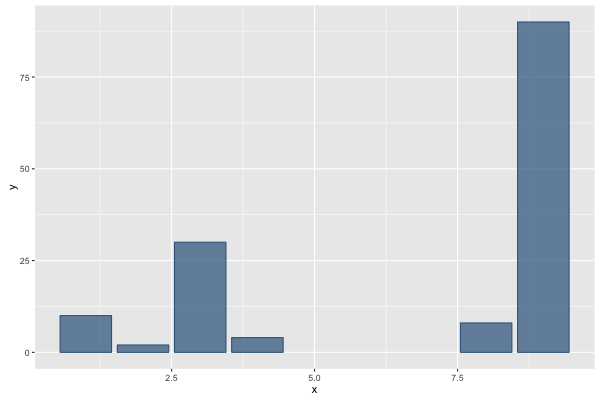

In [14]:
%%R -i dat -w 600 -h 400 -u px
# ^ if you add a -i <python_variable> flag, the data will be converted and sent to the R session
#   the other flags are controlling plot size

ggplot(dat, aes(x=x, y=y)) +
  geom_bar_delta(stat='identity')